# Ultrametric Matrix Distance: Patient Comparison

Compute ultrametric matrix distances (euclidean, cosine, correlation) across phases for every patient, per EEG band.
Plots show, for each band and metric, phase-by-phase distance matrices side-by-side for all patients.

In [1]:
%matplotlib inline
# Core imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Project helpers
from lrgsglib import *
move_to_rootf(pathname='lrg_eegfc')
from lrg_eegfc import *

# Specific utilities
from lrgsglib.utils.basic.linalg import ultrametric_matrix_distance
from lrgsglib.utils.lrg.infocomm import extract_ultrametric_matrix
from lrg_eegfc.utils.corrmat import process_network_for_phase
from lrg_eegfc.utils.datamanag.loaders import load_data_dict
from lrg_eegfc.config.const import PHASE_LABELS, BRAIN_BANDS, PATIENTS_LIST, BRAIN_BAND_LABELS

# Figure output path
path_figs = Path('data') / 'figures' / 'new_ultrametric_distance_pat_comparison'
path_figs.mkdir(parents=True, exist_ok=True)

phase_labels = list(PHASE_LABELS)
bands = list(BRAIN_BANDS.keys())
patients = list(PATIENTS_LIST)
metrics = ['euclidean', 'cosine', 'correlation']

# Correlation network protocol (consistent with other notebooks)
correlation_protocol = dict(threshold=0, spectral_cleaning=False)

print(f'Patients: {patients}')
print(f'Phases: {phase_labels}')
print(f'Bands: {bands}')


Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc
Patients: ['Pat_03', 'Pat_02']
Phases: ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
Bands: ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']


## Load Data

In [2]:
data_dict, int_label_map = load_data_dict()
print('✓ Data loaded')

✓ Data loaded


## Build Ultrametric Matrices per Patient, Phase, Band

In [3]:
def compute_ultrametrics_for_patient(patient: str, filter_order: int = 1):
    """
    For a given patient, compute ultrametric matrices per (phase, band).
    Returns a nested dict: U[band][phase] -> np.ndarray or None.
    """
    U = {b: {} for b in bands}

    # Labels for nodes (channel labels)
    pin_labels = int_label_map[patient]['label']

    for phase in phase_labels:
        data_pat_phase = data_dict[patient][phase]
        data_pat_phase_ts = data_pat_phase['data']
        fs_raw = data_pat_phase.get('fs', None)
        fs = float(np.asarray(fs_raw).flat[0]) if fs_raw is not None else 1000.0

        for band in bands:
            G, label_dict, lnkgM, clTh, corr_mat, dists = process_network_for_phase(
                data_pat_phase_ts, fs, band, correlation_protocol, pin_labels, filter_order=filter_order
            )
            if lnkgM is None or G is None:
                U[band][phase] = None
                continue
            try:
                U[band][phase] = extract_ultrametric_matrix(lnkgM, G.number_of_nodes())
            except Exception as e:
                print(f'[WARN] {patient} {phase} {band}: failed to extract ultrametric ({e})')
                U[band][phase] = None
    return U

# Compute for all patients
ultra_by_pat = {}  # ultra_by_pat[patient][band][phase] -> U matrix or None
for pat in patients:
    print(f'Computing ultrametrics for {pat} ...')
    ultra_by_pat[pat] = compute_ultrametrics_for_patient(pat)
print('✓ Ultrametrics computed for all patients')


Computing ultrametrics for Pat_03 ...


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0068 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0078 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0098 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


Computing ultrametrics for Pat_02 ...


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


✓ Ultrametrics computed for all patients


In [13]:
data_pat_phase = data_dict['Pat_03']['taskTest']
pin_labels = int_label_map['Pat_03']['label']
data_pat_phase_ts = data_pat_phase['data']
fs_raw = data_pat_phase.get('fs', None)
fs = float(np.asarray(fs_raw).flat[0]) if fs_raw is not None else 1000.0

G, label_dict, lnkgM, clTh, corr_mat, dists = process_network_for_phase(
    data_pat_phase_ts, fs, 'high_gamma', correlation_protocol, pin_labels, filter_order=1, scaling_factor=0.9
)

G.number_of_nodes()

121

## Phase Distance Matrices per Patient, Band, Metric

In [8]:
for metric in metrics:
    print(f'Metric: {metric}')
    for band in bands:
        for pat in patients:
            for i, pi in enumerate(phase_labels):
                for j, pj in enumerate(phase_labels):
                    U1 = ultra_by_pat[pat][band].get(pi)
                    U2 = ultra_by_pat[pat][band].get(pj)
                    if U1.shape != U2.shape:
                        print(f'Shape mismatch: {U1.shape} vs {U2.shape}')
                        print(band, pi, pj, pat)

Metric: euclidean
Shape mismatch: (122, 122) vs (121, 121)
high_gamma rsPre taskTest Pat_03
Shape mismatch: (122, 122) vs (121, 121)
high_gamma taskLearn taskTest Pat_03
Shape mismatch: (121, 121) vs (122, 122)
high_gamma taskTest rsPre Pat_03
Shape mismatch: (121, 121) vs (122, 122)
high_gamma taskTest taskLearn Pat_03
Shape mismatch: (121, 121) vs (122, 122)
high_gamma taskTest rsPost Pat_03
Shape mismatch: (122, 122) vs (121, 121)
high_gamma rsPost taskTest Pat_03
Metric: cosine
Shape mismatch: (122, 122) vs (121, 121)
high_gamma rsPre taskTest Pat_03
Shape mismatch: (122, 122) vs (121, 121)
high_gamma taskLearn taskTest Pat_03
Shape mismatch: (121, 121) vs (122, 122)
high_gamma taskTest rsPre Pat_03
Shape mismatch: (121, 121) vs (122, 122)
high_gamma taskTest taskLearn Pat_03
Shape mismatch: (121, 121) vs (122, 122)
high_gamma taskTest rsPost Pat_03
Shape mismatch: (122, 122) vs (121, 121)
high_gamma rsPost taskTest Pat_03
Metric: correlation
Shape mismatch: (122, 122) vs (121, 121

In [14]:
# results[metric][band][patient] -> (n_phase x n_phase) matrix
results = {m: {b: {} for b in bands} for m in metrics}
n = len(phase_labels)

for metric in metrics:
    print(f'Metric: {metric}')
    for band in bands:
        for pat in patients:
            dm = np.full((n, n), np.nan, dtype=float)
            for i, pi in enumerate(phase_labels):
                for j, pj in enumerate(phase_labels):
                    if i == j:
                        dm[i, j] = 0.0
                        continue
                    U1 = ultra_by_pat[pat][band].get(pi)
                    U2 = ultra_by_pat[pat][band].get(pj)
                    if U1 is None or U2 is None or U1.shape != U2.shape:
                        dm[i, j] = np.nan
                    else:
                        dm[i, j] = ultrametric_matrix_distance(U1, U2, metric=metric)
            results[metric][band][pat] = dm
    print('  ✓ done')

print('✓ All phase-distance matrices computed')

Metric: euclidean
  ✓ done
Metric: cosine
  ✓ done
Metric: correlation
  ✓ done
✓ All phase-distance matrices computed


## Plot: Side-by-Side Patients per Band and Metric

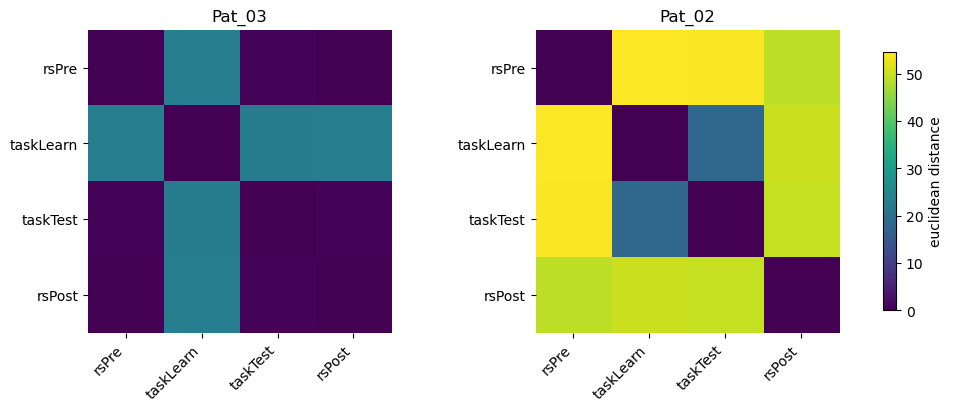

Saved: data/figures/new_ultrametric_distance_pat_comparison/euclidean/delta.png


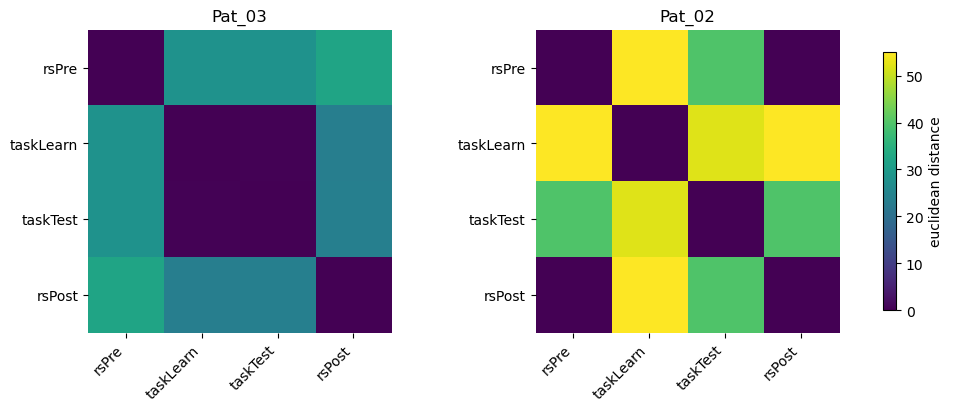

Saved: data/figures/new_ultrametric_distance_pat_comparison/euclidean/theta.png


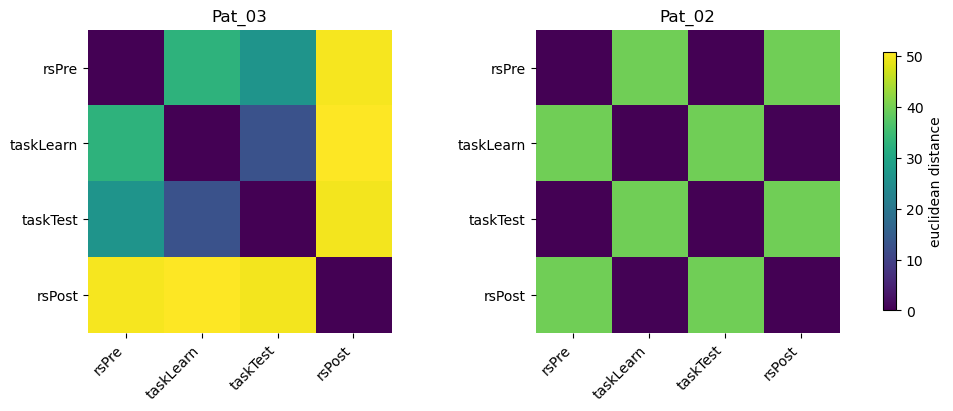

Saved: data/figures/new_ultrametric_distance_pat_comparison/euclidean/alpha.png


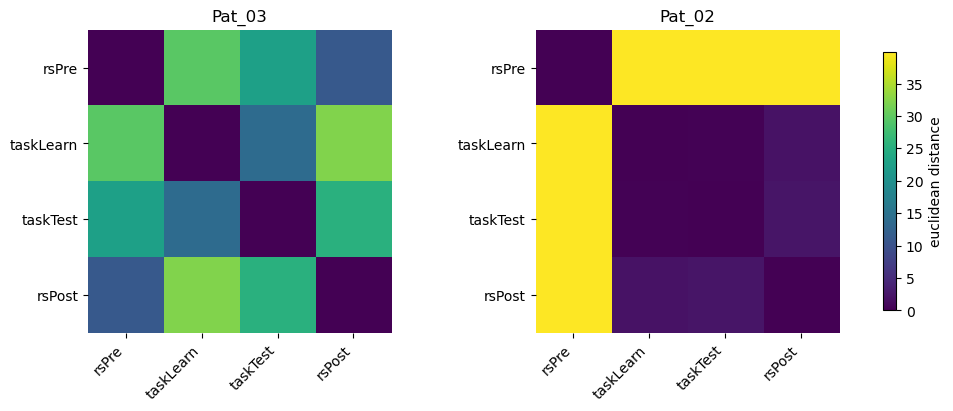

Saved: data/figures/new_ultrametric_distance_pat_comparison/euclidean/beta.png


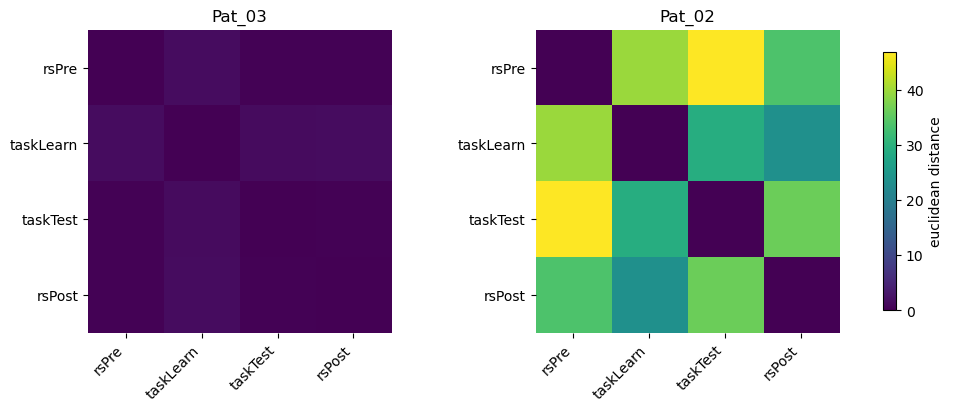

Saved: data/figures/new_ultrametric_distance_pat_comparison/euclidean/low_gamma.png


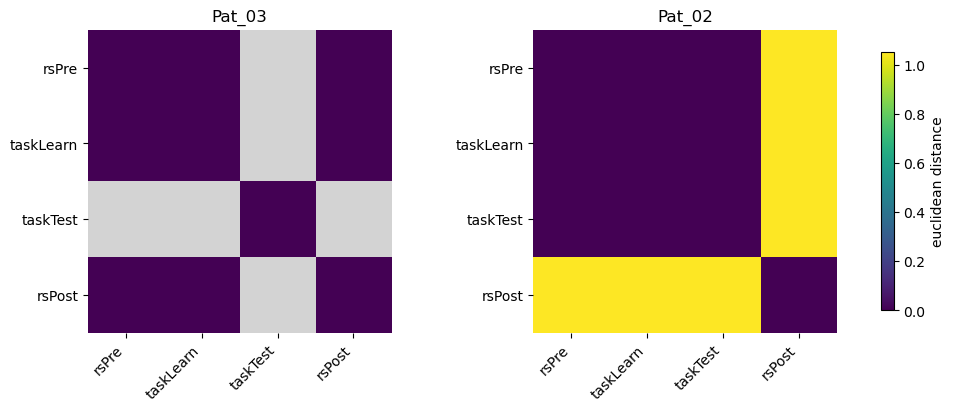

Saved: data/figures/new_ultrametric_distance_pat_comparison/euclidean/high_gamma.png


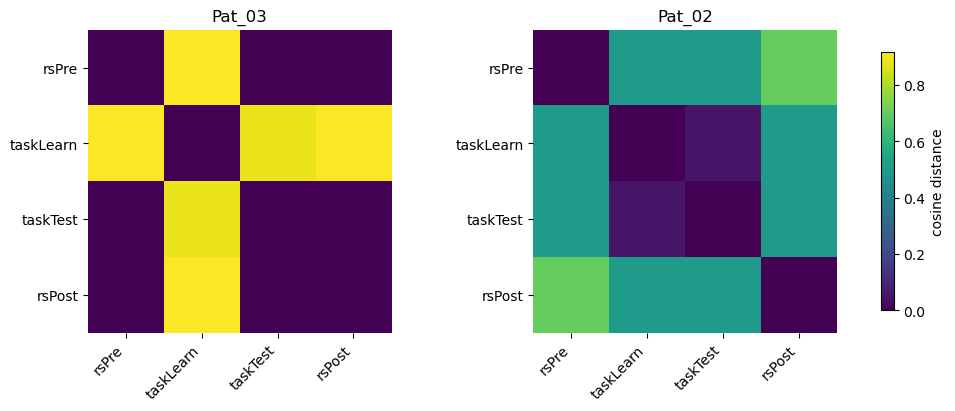

Saved: data/figures/new_ultrametric_distance_pat_comparison/cosine/delta.png


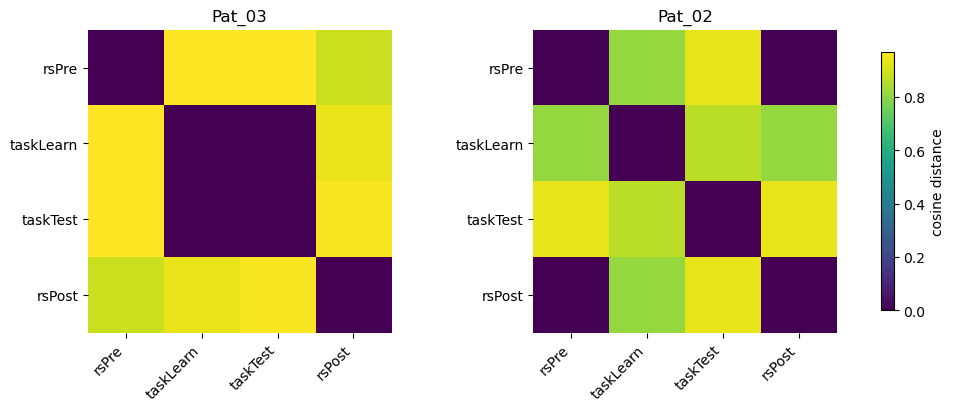

Saved: data/figures/new_ultrametric_distance_pat_comparison/cosine/theta.png


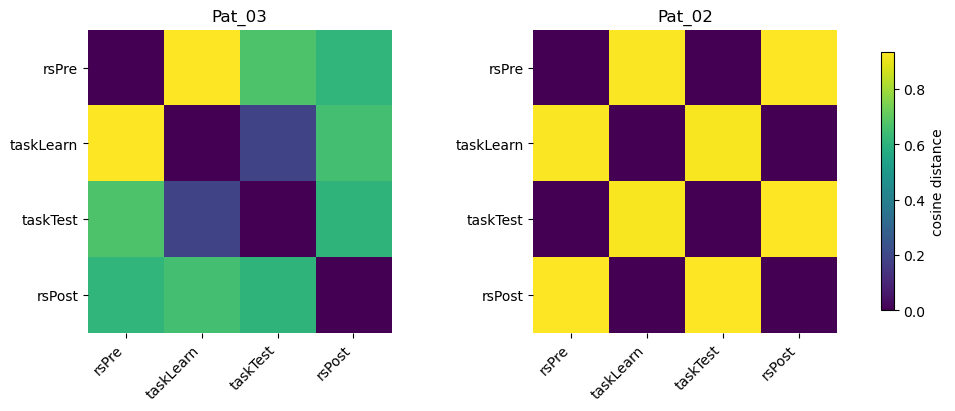

Saved: data/figures/new_ultrametric_distance_pat_comparison/cosine/alpha.png


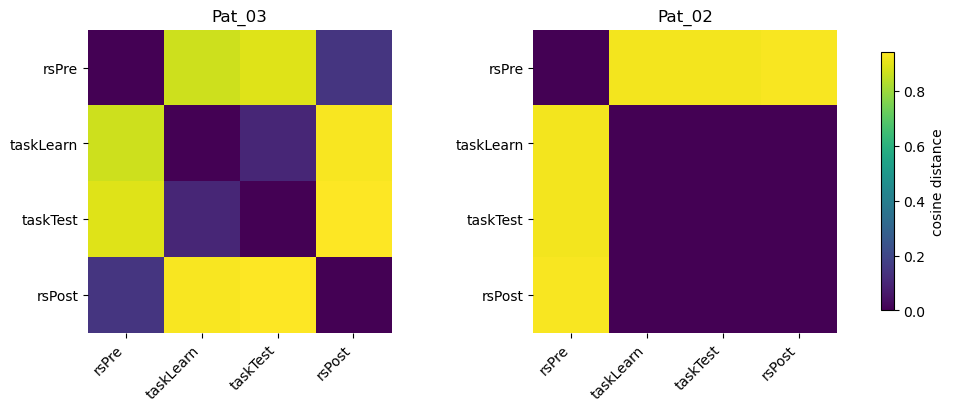

Saved: data/figures/new_ultrametric_distance_pat_comparison/cosine/beta.png


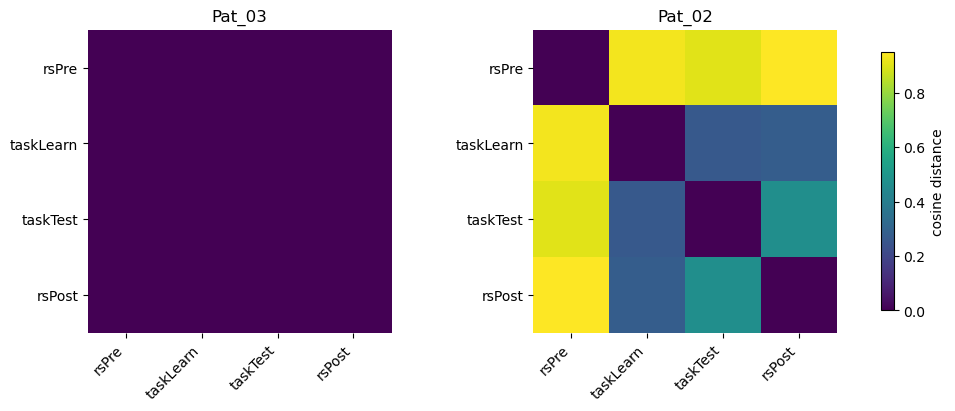

Saved: data/figures/new_ultrametric_distance_pat_comparison/cosine/low_gamma.png


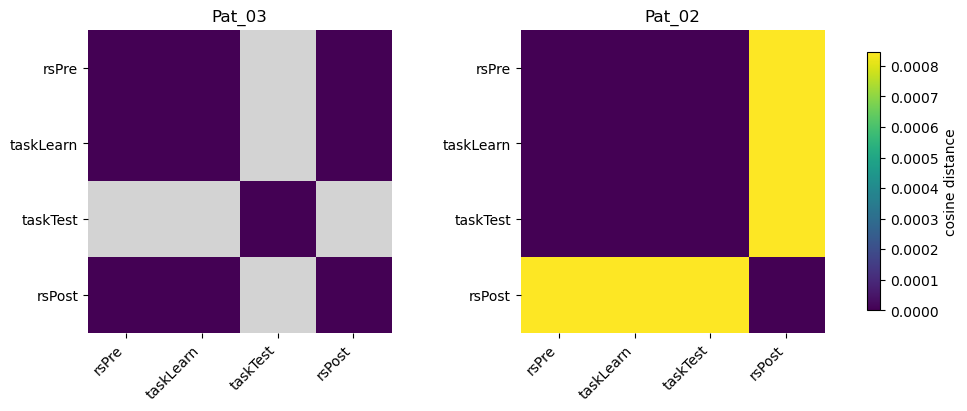

Saved: data/figures/new_ultrametric_distance_pat_comparison/cosine/high_gamma.png


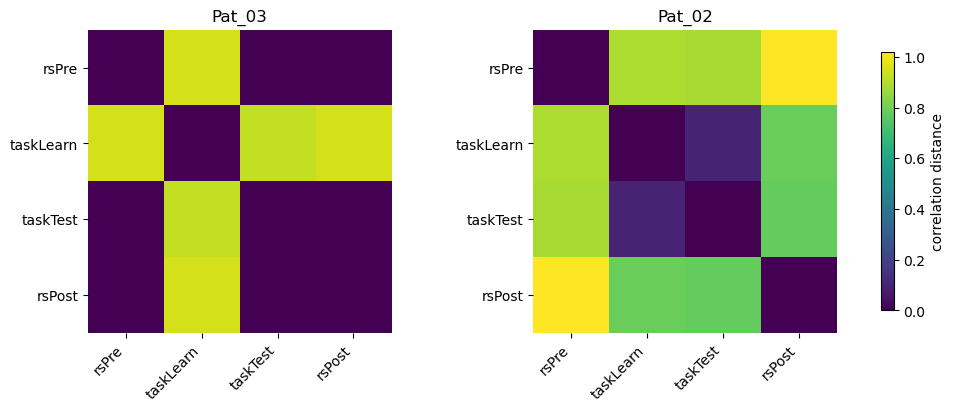

Saved: data/figures/new_ultrametric_distance_pat_comparison/correlation/delta.png


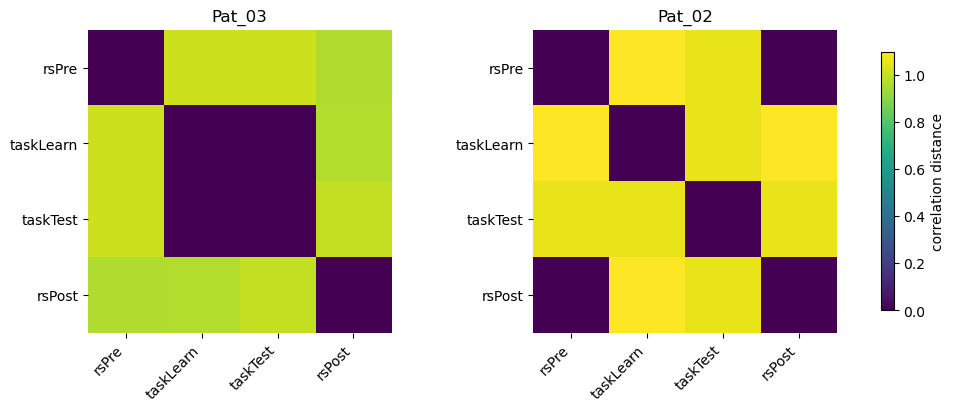

Saved: data/figures/new_ultrametric_distance_pat_comparison/correlation/theta.png


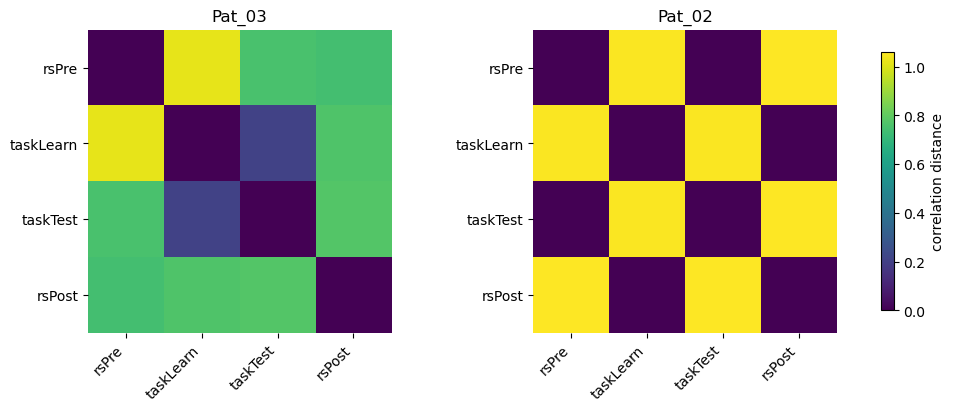

Saved: data/figures/new_ultrametric_distance_pat_comparison/correlation/alpha.png


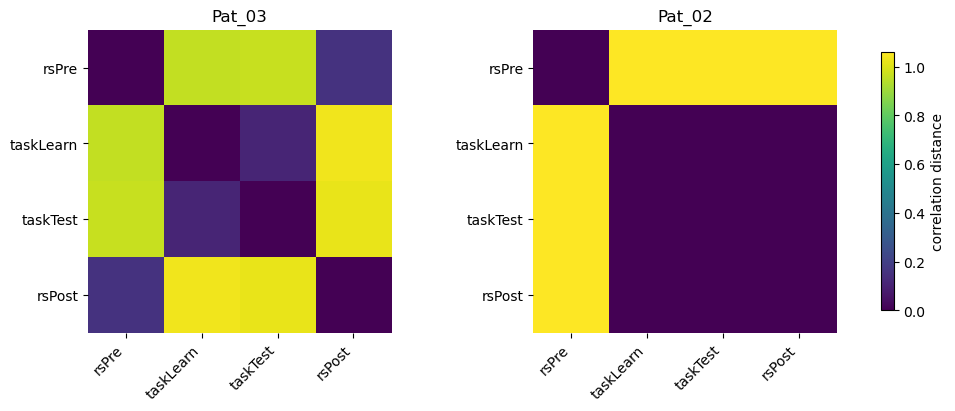

Saved: data/figures/new_ultrametric_distance_pat_comparison/correlation/beta.png


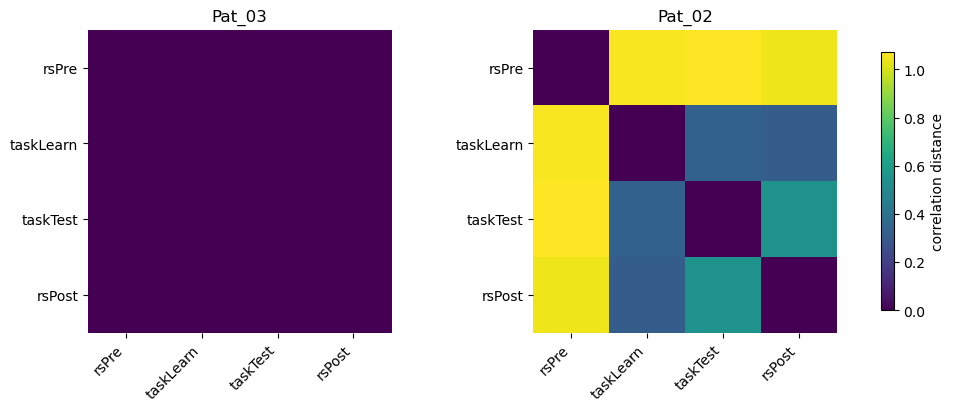

Saved: data/figures/new_ultrametric_distance_pat_comparison/correlation/low_gamma.png


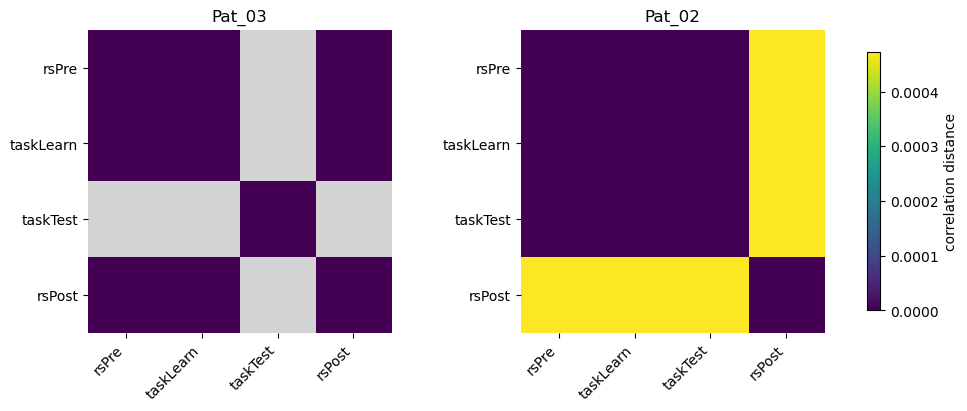

Saved: data/figures/new_ultrametric_distance_pat_comparison/correlation/high_gamma.png
✓ All figures generated


In [19]:
def plot_band_metric_side_by_side(metric: str, band: str):
    # Determine shared color scale across patients (ignore NaNs)
    vmax = 0.0
    for pat in patients:
        m = results[metric][band].get(pat)
        if m is not None and np.isfinite(m).any():
            vmax = max(vmax, np.nanmax(m))
    if vmax == 0.0:
        print(f'[SKIP] No finite values for {metric} / {band}')
        return

    fig, axes = plt.subplots(1, len(patients), figsize=(4*len(patients)+2, 4), constrained_layout=True)
    if len(patients) == 1:
        axes = [axes]

    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='lightgray')

    for ax, pat in zip(axes, patients):
        M = results[metric][band][pat]
        im = ax.imshow(M, vmin=0.0, vmax=vmax, cmap=cmap, aspect='equal')
        ax.set_title(f"{pat}")
        ax.set_xticks(range(len(phase_labels)))
        ax.set_yticks(range(len(phase_labels)))
        ax.set_xticklabels(phase_labels, rotation=45, ha='right')
        ax.set_yticklabels(phase_labels)
        for spine in ax.spines.values():
            spine.set_visible(False)

    cbar = fig.colorbar(im, ax=axes, shrink=0.85)
    cbar.set_label(f'{metric} distance')
    band_label = BRAIN_BAND_LABELS.get(band, band)

    outdir = path_figs / metric
    outdir.mkdir(parents=True, exist_ok=True)
    outfile = outdir / f'{band}.png'
    fig.savefig(outfile, dpi=200, bbox_inches='tight')
    plt.show()
    print(f'Saved: {outfile}')

# Generate all plots
for metric in metrics:
    for band in bands:
        plot_band_metric_side_by_side(metric, band)

print('✓ All figures generated')
